# Default Setting

Executed in Colab pro environment.

* ML Framework
   - Python 3.7.10
   - Tensorflow 2.5.0

* Hardware
   - RAM: 12.7G 
   - CPU: Intel(R) Xeon(R) CPU @ 2.30GHz (1core)
   - GPU: Tesla P100-PCIE-16GB

# 0. import packages

In [1]:
# 빗썸 가상화폐 데이터 모듈
!pip install -q pybithumb

In [2]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import pybithumb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# 2. Data Preprocessing

In [3]:
mydf = pybithumb.get_ohlcv("ETH",interval='hour').reset_index()

In [4]:
mydf.head()

,time,open,high,low,close,volume
0,2020-11-30 16:00:00,637000.0,639500.0,636500.0,638000.0,2856.190998
1,2020-11-30 17:00:00,638000.0,638500.0,623500.0,629500.0,9376.482516
2,2020-11-30 18:00:00,629500.0,632500.0,624000.0,630000.0,4245.008116
3,2020-11-30 19:00:00,630000.0,637500.0,629000.0,634000.0,1781.313382
4,2020-11-30 20:00:00,634000.0,646000.0,634000.0,643000.0,4348.065615


In [5]:
plt.rcParams["figure.figsize"] = (15,10)

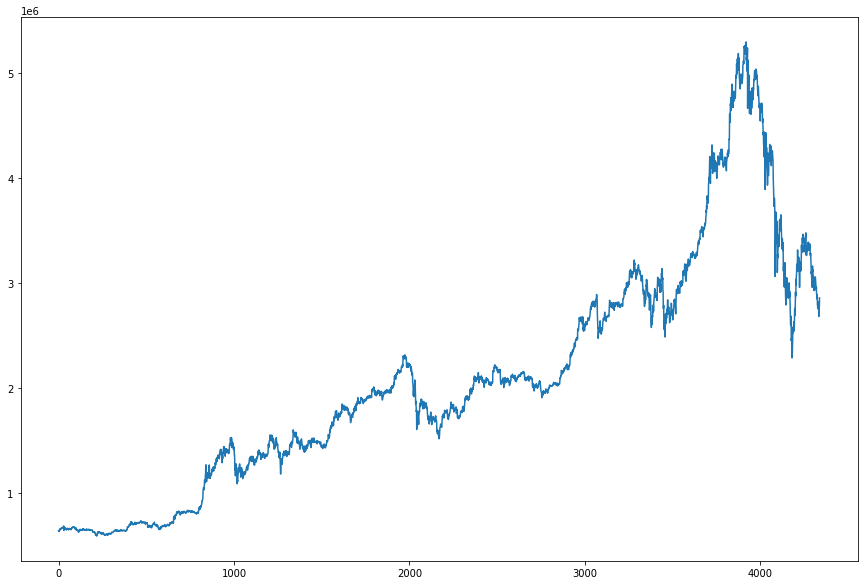

In [6]:
plt.plot(mydf['open'])

In [7]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        array = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

In [8]:
def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [9]:
training_data, scaler = preprocess(mydf['open'], window_size=10)

In [10]:
X_train,X_test,y_train,y_test = make_dataset(training_data, t = 168)

# MAE, MSE, RMSE

In [11]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

# GRU-adaboost FIT

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [14]:
# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

In [15]:
final_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
112/112 [==============================] - 3s 8ms/step - loss: 0.0047
Epoch 2/20
112/112 [==============================] - 1s 8ms/step - loss: 8.7739e-04
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 7.9680e-04
Epoch 4/20
112/112 [==============================] - 1s 8ms/step - loss: 7.5188e-04
Epoch 5/20
112/112 [==============================] - 1s 8ms/step - loss: 6.2448e-04
Epoch 6/20
112/112 [==============================] - 1s 8ms/step - loss: 6.1256e-04
Epoch 7/20
112/112 [==============================] - 1s 8ms/step - loss: 5.5657e-04
Epoch 8/20
112/112 [==============================] - 1s 8ms/step - loss: 5.1312e-04
Epoch 9/20
112/112 [==============================] - 1s 8ms/step - loss: 4.8096e-04
Epoch 10/20
112/112 [==============================] - 1s 8ms/step - loss: 4.4337e-04
Epoch 11/20
112/112 [==============================] - 1s 8ms/step - loss: 4.3652e-04
Epoch 12/20
112/112 [==============================] - 1s 8ms/step 

AdaBoostRegressor(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3c903bd790>,
                  learning_rate=1.0, loss='linear', n_estimators=5,
                  random_state=42)

In [16]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

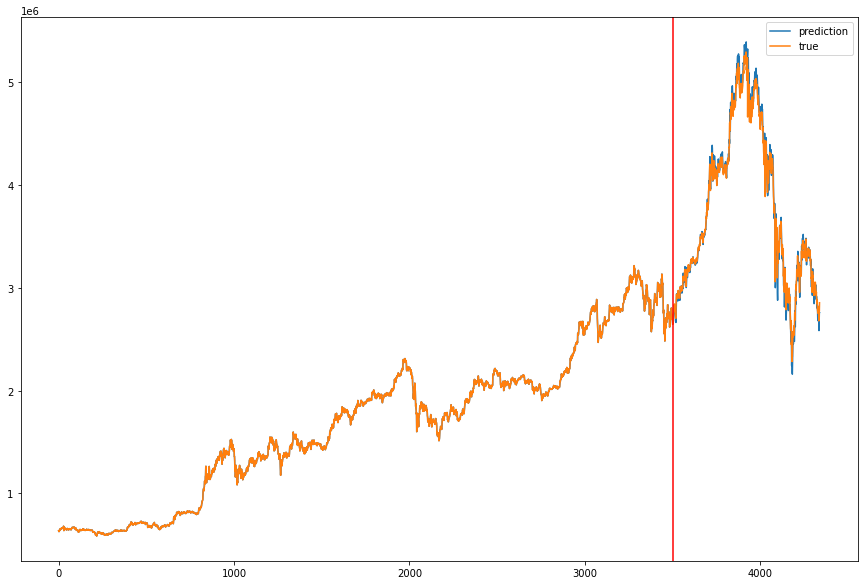

In [17]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.show()

In [18]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [19]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

6.11e+04
7.55e+09
8.69e+04


# LSTM-adaboost FIT

In [20]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [21]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [22]:
LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

In [23]:
final_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/20
112/112 [==============================] - 2s 8ms/step - loss: 0.0033
Epoch 2/20
112/112 [==============================] - 1s 8ms/step - loss: 0.0010
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 7.7611e-04
Epoch 4/20
112/112 [==============================] - 1s 8ms/step - loss: 7.5878e-04
Epoch 5/20
112/112 [==============================] - 1s 8ms/step - loss: 7.1609e-04
Epoch 6/20
112/112 [==============================] - 1s 8ms/step - loss: 6.1691e-04
Epoch 7/20
112/112 [==============================] - 1s 8ms/step - loss: 5.6365e-04
Epoch 8/20
112/112 [==============================] - 1s 8ms/step - loss: 5.1398e-04
Epoch 9/20
112/112 [==============================] - 1s 8ms/step - loss: 4.6796e-04
Epoch 10/20
112/112 [==============================] - 1s 8ms/step - loss: 4.5956e-04
Epoch 11/20
112/112 [==============================] - 1s 8ms/step - loss: 4.5767e-04
Epoch 12/20
112/112 [==============================] - 1s 8ms/step - lo

AdaBoostRegressor(base_estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f3c5a53b510>,
                  learning_rate=1.0, loss='linear', n_estimators=5,
                  random_state=42)

In [24]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

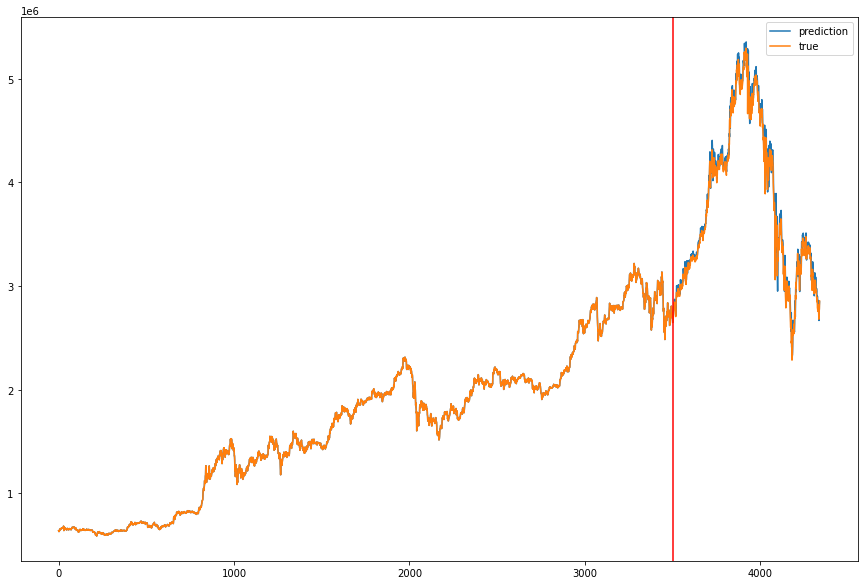

In [25]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.show()

In [26]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [27]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

6.26e+04
7.58e+09
8.71e+04


# GRU Fit

In [28]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [29]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20
89/89 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 2.0447e-04
Epoch 2/20
89/89 [==============================] - 1s 9ms/step - loss: 5.8214e-04 - val_loss: 1.4711e-04
Epoch 3/20
89/89 [==============================] - 1s 9ms/step - loss: 5.3340e-04 - val_loss: 8.2336e-05
Epoch 4/20
89/89 [==============================] - 1s 9ms/step - loss: 4.5673e-04 - val_loss: 7.6420e-05
Epoch 5/20
89/89 [==============================] - 1s 9ms/step - loss: 4.2096e-04 - val_loss: 1.1056e-04
Epoch 6/20
89/89 [==============================] - 1s 9ms/step - loss: 3.8690e-04 - val_loss: 7.7676e-05
Epoch 7/20
89/89 [==============================] - 1s 9ms/step - loss: 3.5702e-04 - val_loss: 9.1862e-05
Epoch 8/20
89/89 [==============================] - 1s 9ms/step - loss: 3.4368e-04 - val_loss: 6.9872e-05
Epoch 9/20
89/89 [==============================] - 1s 9ms/step - loss: 3.2157e-04 - val_loss: 1.6223e-04
Epoch 10/20
89/89 [==============================

In [31]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

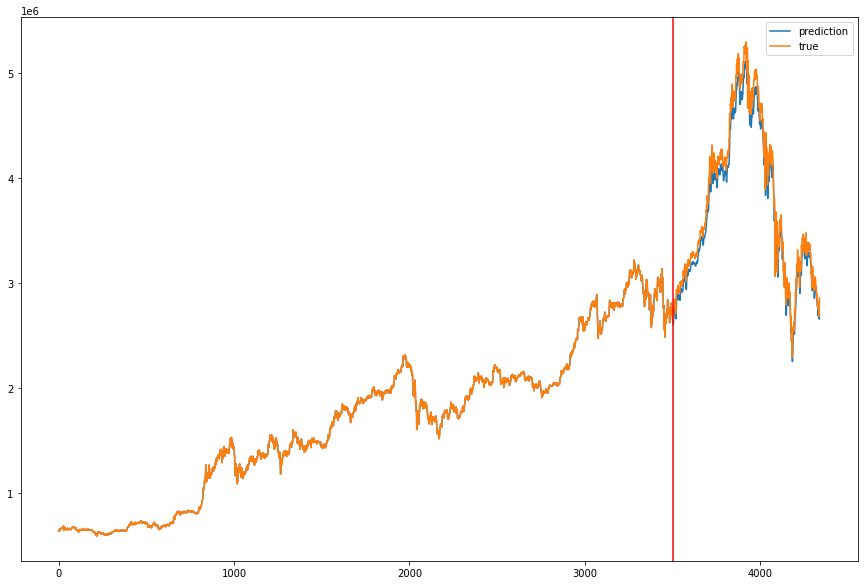

In [32]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.show()

In [33]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [34]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

1.12e+05
1.75e+10
1.32e+05


# LSTM FIT

In [35]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [37]:
model.fit(X_train,y_train,batch_size=30,epochs=20,validation_split=0.2)

Epoch 1/20
89/89 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 1.9394e-04
Epoch 2/20
89/89 [==============================] - 1s 9ms/step - loss: 5.5680e-04 - val_loss: 3.3705e-04
Epoch 3/20
89/89 [==============================] - 1s 9ms/step - loss: 4.8834e-04 - val_loss: 6.8191e-04
Epoch 4/20
89/89 [==============================] - 1s 9ms/step - loss: 5.0069e-04 - val_loss: 1.6152e-04
Epoch 5/20
89/89 [==============================] - 1s 9ms/step - loss: 4.2484e-04 - val_loss: 2.5867e-04
Epoch 6/20
89/89 [==============================] - 1s 9ms/step - loss: 3.9851e-04 - val_loss: 1.7761e-04
Epoch 7/20
89/89 [==============================] - 1s 9ms/step - loss: 3.4623e-04 - val_loss: 4.1110e-04
Epoch 8/20
89/89 [==============================] - 1s 9ms/step - loss: 3.2671e-04 - val_loss: 8.8955e-04
Epoch 9/20
89/89 [==============================] - 1s 9ms/step - loss: 3.1470e-04 - val_loss: 2.1841e-04
Epoch 10/20
89/89 [==============================

In [38]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

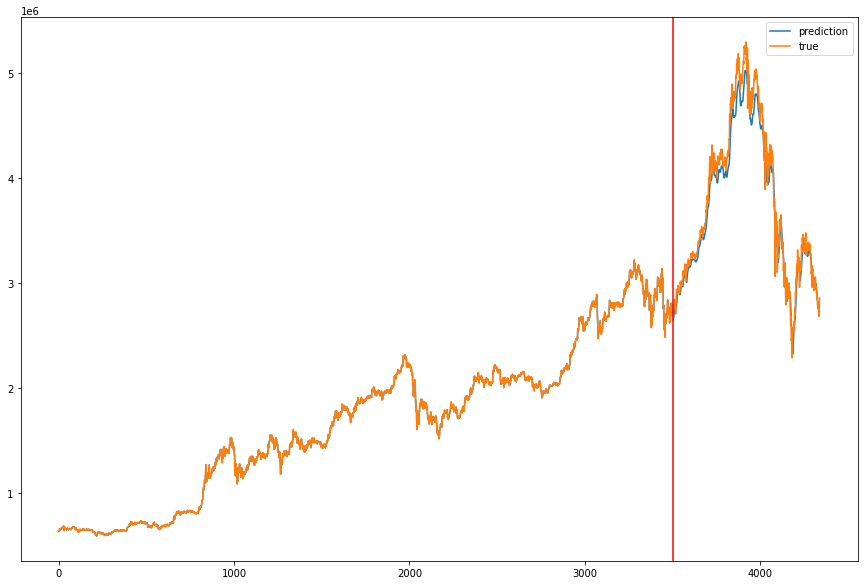

In [39]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.show()

In [40]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [41]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

1.17e+05
2.05e+10
1.43e+05
